In [1]:
module FractionalEM
  using GradientRobustMultiPhysics
  using ExtendableGrids
  using GridVisualize
  using ExtendableSparse
  using SpecialFunctions

  """
    ReactionConvectionDiffusionOperator(α, β, ϵ)

    TBW
  """
  function ReactionConvectionDiffusionOperator(γ, β, ϵ)
    function action_kernel!(result, input, x, t)
        β.x = x
        β.time = t
        eval_data!( γ )
        eval_data!( β )
        # α * u_h + β_1 * ∇_xu_h + β_2 ∇_y u_h
        result[1] = γ.val[1] * input[1] + β.val[1] * input[2] + β.val[2] * input[3]
        # Laplacian
        result[2] = ϵ * input[2]
        result[3] = ϵ * input[3]
        return nothing
    end
    action = Action(action_kernel!, [3, 3], dependencies = "XT", bonus_quadorder = max(γ.bonus_quadorder, β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity, Gradient}, OperatorPair{Identity, Gradient}], action;
    name=" ϵ(∇ u, ∇ v) + (γ u + β⋅∇u, v)", transposed_assembly = true)
  end

  """
    get_problem_data(ν)

  TBW
  """
  function get_problem_data(ϵ, p=1.0, α=1.0)
    γ = DataFunction([0.0]; name = "γ")
    β = DataFunction([0.0,0.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^p
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        dt_u = x[1] * gamma(p+1)/gamma(p-α+1)*t^(p-α)
        result[1] = dt_u-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end 

  function boundary_layer(ϵ, p=1.0, α=1.0)
    γ = DataFunction([1.0]; name = "γ")
    β = DataFunction([2.0,3.0]; name = "β")
    function exact!(result, x, t)
      expx =exp(2*(x[1]-1)*ϵ);
      expy =exp(3*(x[2]-1)*ϵ);
      expxy=exp((2*(x[1]-1)+3*(x[2]-1))*ϵ);
      # u = x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy;
      result[1] = (x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy)* (t^(p+1)+t^p);
    end 
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    function exact_ut!(result, x, t)
      expx =exp(2*(x[1]-1)*ϵ);
      expy =exp(3*(x[2]-1)*ϵ);
      expxy=exp((2*(x[1]-1)+3*(x[2]-1))*ϵ);      
      result[1] = (x[1]*x[2]^2-x[2]^2*expx-x[1]*expy+expxy)* (gamma(p+1)/gamma(p-α+1)*t^(p-α)+gamma(p+2)/gamma(p+1-α+1)*t^(p+1-α));
    end 
    dtu = DataFunction(exact_ut!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)    
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)
        result[1] = dtu(x,t)[1] - ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # γ * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end
  
  function main(; ϵ=1.0, nrefinements=2, order=1, nsteps=10, Tf=1.0, α=1, tpower=1.0, verbosity=0, stab_param=1e-2)
    aj = zeros(nsteps);     
    aj[1] = 1.0;
    for j = 2:nsteps
      aj[j] = (j)^(1-α) - (j-1)^(1-α)
    end
    #@show aj
    bj = zeros(nsteps+1); 
    bj[1] = aj[1]
    bj[nsteps+1] = -aj[nsteps]
    for j=2:nsteps
      bj[nsteps-j+2]= aj[nsteps-j+2] - aj[nsteps-j+1]
    end
    #@show bj    
    temp = sum(bj)
    #@show temp # sum must be zero

    ## finite elements and bilinear forms
    # Prepare the matrices and rhs coming from space discretization 
    ## set log level
    set_verbosity(verbosity)    
    ## negotiate data functions to the package
    γ, β, u, ∇u, f = boundary_layer(ϵ, tpower, α)
    # choose a finite element type
    FEType = H1Pk{1,2,order}
    xgrid = uniform_refine(grid_unitsquare(Triangle2D), nrefinements)
    FES = FESpace{FEType}(xgrid)
    Solution = FEVector(FES)
    n_dofs = FES.ndofs
    interpolate!(Solution[1], u; time = 0.0)    

    M = FEMatrix(FES)
    assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
    # @show M.entries
    # println(size(M[1,1]))
    @show FES.ndofs
    A = FEMatrix(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=0.0)

    if stab_param > 0 
      xFaceVolumes = xgrid[FaceVolumes]
      xFaceVolumes::Array{Float64,1} = xgrid[FaceVolumes]
      stab_action = Action((result,input,item) -> (result .= input .* xFaceVolumes[item[1]]^2), [2,2]; name = "stabilisation action", dependencies = "I")
      JumpStabilisation = BilinearForm([Jump(Gradient), Jump(Gradient)], stab_action; AT = ON_IFACES, factor = stab_param, name = "τ |F|^2 [∇(#A)]⋅[∇(#T)]")
      S = FEMatrix(FES)
      assemble_operator!(S[1,1], JumpStabilisation)
    end
    # @show A.entries

    rhs = FEVector(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
    # @show rhs.entries

    dt = Array{BoundaryData,1}(undef,0)
    push!(dt, BoundaryData(BestapproxDirichletBoundary; regions = [1,2,3,4], data = u))
    dofs = boundarydata!(Solution[1], dt; time = 0.0)
    
    t0 = 0.0
    tau = (Tf - t0)/nsteps
    @show nrefinements, nsteps

    V1 = zeros(Float64, FES.ndofs, 1)
    Mu0 = zeros(Float64, FES.ndofs)
    temp = zeros(Float64, FES.ndofs, nsteps)    
    temp[:, 1] = Solution[1].entries

    SystemMatrix = FEMatrix(FES)
    # @show SystemMatrix
    SystemRHS = FEVector(FES)
    SystemSol = FEVector(FES)

    # SolVector = Array{FEVector{Float64}}([])
    Sols = Array{FEVector}(undef, nsteps)
    # push!(SolVector, Solution)

    scale = tau^α*gamma(2-α)
    oldL2 = zero(Float64); oldh1 = zero(Float64)
    eL2 = zero(Float64); eh1 = zero(Float64)

    # for m in 1:nsteps + 1
    m = 1;
    # while t0 <= Tf - 1e-10
    #   t0 = t0 + tau
    #   m += 1
    #   println(m, " ", t0)
    #   for j in 2 : m-1
    #     println(m, " ", j, " ", m-j+1, " ", bj[m-j+1], " ", j-1)
    #   end
    #   println()
    # end

    for m=2:nsteps
      t0 = t0+tau
      fill!(SystemRHS.entries, 0)
      fill!(rhs.entries, 0)
      assemble_operator!(rhs[1], LinearForm(Identity, f), time= t0 )
      V1[:, 1] = rhs.entries
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
      #@show aj[m-1]
      addblock!(SystemRHS[1], Mu0; factor= aj[m-1]/scale)
      for j=2:m-1
        # println(m," ", j, " ", m-j+1, " ", bj[m-j+1])
        addblock!(SystemRHS[1], M.entries*temp[:,j]; factor= -bj[m-j+1]/scale)
      end

      fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
      fill!(A.entries.cscmatrix.nzval, 0)
      # assembling the matrices with coefficients depending on time     
      assemble_operator!(A[1, 1], ReactionConvectionDiffusionOperator(γ, β, ϵ); time=t0 )

      if stab_param > 0 
        fill!(S.entries.cscmatrix.nzval, 0)
        assemble_operator!(S[1,1], JumpStabilisation; time=t0)
        addblock!(SystemMatrix[1,1], S[1,1]; factor = 1.0)
      end

      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/scale)
      addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)

      flush!(SystemMatrix.entries)      
      #@show SystemRHS.entries
      dofs = boundarydata!(SystemSol[1], dt; time = t0)        
      for dof in dofs
        SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
        SystemMatrix[1,1][dof,dof] = 1e60
      end
      SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries
      for j = 1 : n_dofs 
        Solution[1][j] = SystemSol[1][j]
      end
      # push!(SolVector, Solution)
      temp[:, m] = Solution[1].entries

      L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
      l2 = evaluate(L2Error_u, Solution[1])
      eL2 += (l2 + oldL2) * tau * 0.5
      oldL2 = l2

      h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
      h1 = evaluate(h1erro, Solution[1])
      eh1 += (l2 + oldh1) * tau * 0.5
      oldh1 = h1

      #@show (sqrt(eL2), sqrt(eh1))
    end #endfor time 
    @show (sqrt(eL2))
    (sqrt(eL2), sqrt(eh1))
  end #end main 
end #module 

Main.FractionalEM

In [2]:
ns = [0 1 2 3 4 5]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.FractionalEM.main(;ϵ=1e-5, nrefinements=n, order=1, nsteps=1000, α=0.3, tpower=3, stab_param=0.01)
    push!(eL2, el2)
    push!(eH1, eh1)
end

┌ Warning:  11517736 allocations during ExtendableGrids.ITEMTYPE_CELL volume calculation
└ @ ExtendableGrids ~/.julia/packages/ExtendableGrids/XFxI3/src/derived.jl:937
FES.ndofs = 5
(nrefinements, nsteps) = (0, 1000)
sqrt(eL2) = 0.04706995505914142
FES.ndofs = 13
(nrefinements, nsteps) = (1, 1000)
sqrt(eL2) = 0.008656347171880348
FES.ndofs = 41
(nrefinements, nsteps) = (2, 1000)
sqrt(eL2) = 0.0022644519963555573
FES.ndofs = 145
(nrefinements, nsteps) = (3, 1000)
sqrt(eL2) = 0.0005855292795480057
FES.ndofs = 545
(nrefinements, nsteps) = (4, 1000)
sqrt(eL2) = 0.0001482741851127632
FES.ndofs = 2113
(nrefinements, nsteps) = (5, 1000)


InterruptException: InterruptException:

In [26]:
println("L2: ", eL2)
println("H1: ", eH1)

L2: Any[0.04706995505914142, 0.008656347171880348, 0.0022644519963555573, 0.0005855292795480057, 0.0001482741851127632, 3.716362133017732e-5]
H1: Any[0.22662729857181338, 0.11636932341642667, 0.05868443677616145, 0.029276613110101306, 0.014454479913304967, 0.007135206420962598]


L2: Any[8.646027411675778e-5, 2.958035581188826e-5, 9.758987653576226e-6, 3.1541633855628405e-6, 1.00643819824531e-6]
H1: Any[0.00028467350207102944, 9.921864376161202e-5, 3.299029988771647e-5, 1.0700610657740817e-5, 3.420117607842177e-6]


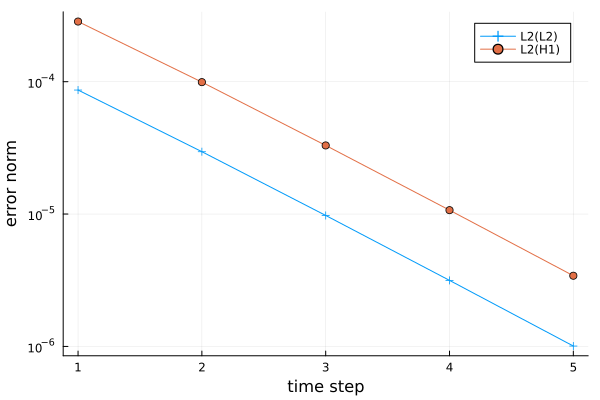

In [3]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")